In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import skimage.io as io
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os
import pickle
import pydicom
from general import DATA_DIR
from metrics import Pfbeta

from sklearn.linear_model import Lasso

In [3]:
train = pd.read_csv(DATA_DIR/'train.csv')

# Load experiment

In [4]:
from datasets import *
from architectures import *
from metrics import *
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
from transforms import *
from configs import *
# from configs_seg import SegBaseline, SegBaseline2
from kuma_utils.utils import sigmoid
from sklearn.metrics import roc_auc_score

In [6]:
def agg_results(cfg, return_target=False):
    with open(f'results/{cfg.name}/predictions.pickle', 'rb') as f:
        predictions = pickle.load(f)
    res_df = []
    for fold_i, (folds, pred_fold, target_fold) in enumerate(
        zip(predictions['folds'], predictions['outoffolds'], predictions['targets'])):

        ds = cfg.dataset(df=train.iloc[folds[1]], image_dir=None)
        for i in range(len(ds)):
            record = {
                'fold': fold_i,
                'pred': sigmoid(pred_fold[i][0]), 
                'prediction_id': f'{ds.pids[i][0]}_{ds.pids[i][1]}'}
            if return_target:
                record['target'] = target_fold[i][0]
            res_df.append(record)
    res_df = pd.DataFrame(res_df)
    return res_df

configs_to_export = [
    Aug07pl2aug2(), 
    Aug07lr0(), Aug07pl3(), 
    Model14(),
    Res02Aux0(), 
    Res02pl1(),
    Res02mod2(),
    Res02mod3(),
]

configs_names = [cfg.name for cfg in configs_to_export]

In [7]:
for icfg, cfg in enumerate(configs_to_export):
    oof_df = agg_results(cfg)
    oof_df.to_csv(f'input/rsna-breast-cancer-detection/oofs/kuma_{cfg.name}.csv', index=False)

In [8]:
for icfg, cfg in enumerate(configs_to_export):
    if icfg == 0:
        oof_df = agg_results(cfg, return_target=True).rename({'pred': f'{cfg.name}'}, axis=1)
    else:
        oof_df = oof_df.merge(
            agg_results(cfg).rename({'pred': f'{cfg.name}'}, axis=1), 
            on=['prediction_id', 'fold'], how='left')

oof_df

,fold,aug_07_pl2_aug2,prediction_id,target,aug_07_lr0,aug_07_pl3,model_14,res_02_aux0,res_02_pl1,res_02_mod2,res_02_mod3
0,0,0.000815,49_L,0.0,0.002173,0.001930,0.002919,0.001288,0.002581,0.001729,0.001636
1,0,0.000814,49_R,0.0,0.001864,0.002849,0.002478,0.002302,0.004041,0.002289,0.000749
2,0,0.000896,72_L,0.0,0.002714,0.001238,0.003905,0.000232,0.001924,0.000783,0.000701
3,0,0.002932,72_R,0.0,0.002600,0.005902,0.003969,0.000421,0.003808,0.003924,0.001739
4,0,0.000349,105_L,0.0,0.001508,0.001191,0.002389,0.008842,0.011191,0.002844,0.008912
...,...,...,...,...,...,...,...,...,...,...,...
23821,3,0.000454,65477_R,0.0,0.001559,0.000542,0.000582,0.000319,0.001966,0.005793,0.003317
23822,3,0.003085,65495_L,0.0,0.001712,0.002317,0.007210,0.001630,0.003510,0.003660,0.001959
23823,3,0.000817,65495_R,0.0,0.001139,0.000803,0.000456,0.000689,0.000503,0.001062,0.001113
23824,3,0.001005,65530_L,0.0,0.002427,0.001739,0.001772,0.002659,0.002213,0.002135,0.002463


In [9]:
metric = PercentilePfbeta(percentile_range=(97.5, 99.0), n_trials=30)
for cfg_name in configs_names:
    score, percentile, threshold = metric(oof_df[cfg_name].values, oof_df['target'].values)
    print(cfg_name, score)


aug_07_pl2_aug2 0.47374062165058944
aug_07_lr0 0.4780278670953912
aug_07_pl3 0.48775055679287305
model_14 0.47058823529411764
res_02_aux0 0.47139588100686497
res_02_pl1 0.48687350835322196
res_02_mod2 0.4844587352625938
res_02_mod3 0.4988713318284424


In [10]:
metric = PercentilePfbeta(percentile_range=(97.5, 99.0), n_trials=30)
for fold in range(4):
    oof_fold = oof_df.query('fold == @fold')
    avg_oof = oof_fold[configs_names].mean(1)
    score, percentile, threshold = metric(avg_oof.values, oof_fold['target'].values)
    print(fold, score)


0 0.5546218487394957
1 0.5535714285714285
2 0.49746192893401014
3 0.5291479820627804


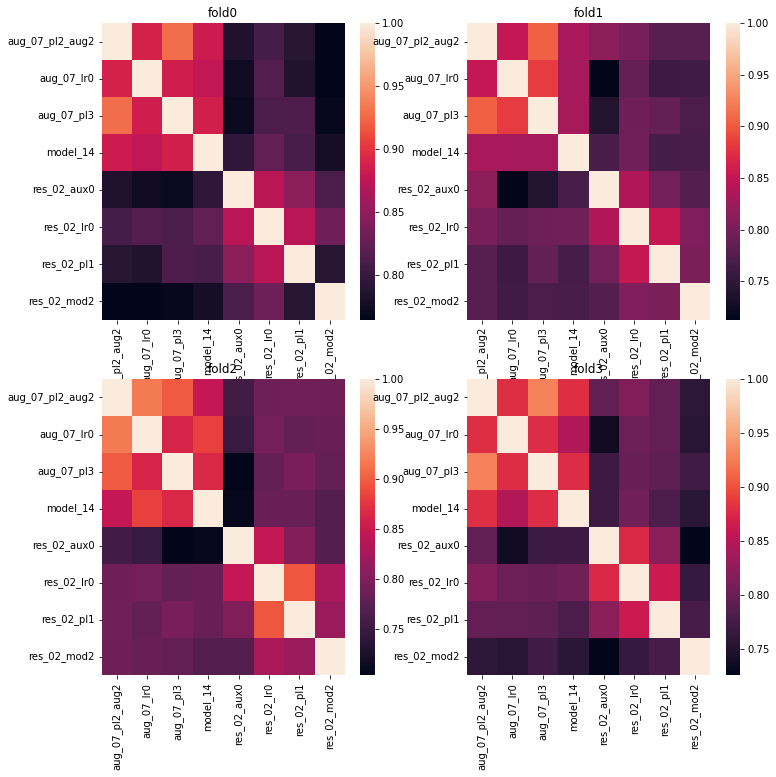

In [11]:
plt.figure(figsize=(12, 12))
for fold, fold_df in oof_df.groupby('fold'):
    plt.subplot(2, 2, fold+1)
    sns.heatmap(fold_df.drop(['fold', 'prediction_id', 'target'], axis=1).corr())
    plt.title(f'fold{fold}')
plt.show()

In [5]:
# for fold in range(4):
#     checkpoint = torch.load(f'results/aug_07_pl0_es0/fold{fold}.pt')
#     plt.plot(pd.DataFrame(checkpoint['all_states'])['valid_monitor'].apply(lambda x: x[0]), label=f'fold{fold}')
# plt.legend()
# plt.show()

In [6]:
# def plot_color_gradients(cmap_name):
#     gradient = np.linspace(0, 1, 256)
#     gradient = np.vstack((gradient, gradient))
#     # Create figure and adjust figure height to number of colormaps
#     plt.figure(figsize=(10, 1))
#     plt.imshow(gradient, aspect='auto', cmap=plt.cm.get_cmap(cmap_name))
#     plt.axis('off')

# plot_color_gradients('jet')

In [7]:
# cfg = Dataset02v0()
# ds = PatientLevelDataset(
#     df=train, image_dir=Path('input/rsna-breast-cancer-detection/image_resized_1024W'),
#     flip_lr=False,
#     preprocess=A.Compose([AutoFlip(), CropROI(threshold=0.1, buffer=160), A.Resize(768, 384)]),
#     transforms=ToTensorV2(),
#     # preprocess=cfg.preprocess['train'],
#     # transforms=cfg.transforms['train']
# )

In [6]:
cfg = Baseline4()
# model = cfg.model(**cfg.model_params)

In [7]:
with open(f'results/{cfg.name}/predictions.pickle', 'rb') as f:
    predictions = pickle.load(f)

In [8]:
# train['fold'] = 0
# for fold_i, (train_idx, valid_idx) in enumerate(predictions['folds']):
#     train.loc[valid_idx, 'fold'] = fold_i
# train.to_csv('train_with_fold.csv', index=False)

In [9]:
SAMPLE_ID = {
    42624, 48001, 48514, 2179, 31107, 23554, 13185, 53255, 
    29192, 59530, 64908, 32527, 13845, 59552, 54816, 49954, 
    55330, 59307, 21934, 63536, 23729, 61490, 61874, 16955, 
    46014, 38727, 64456, 50375, 9162, 55755, 25550, 15696, 
    50002, 58195, 10198, 13016, 25050, 31581, 26333, 29664, 
    8289, 3305, 6637, 48493, 58610, 42231, 12282, 9083, 32252, 39677}

In [18]:
metric = Pfbeta(binarize=True)

In [11]:
# for fold_i, (folds, pred_fold) in enumerate(zip(predictions['folds'], predictions['outoffolds'])):
#     ds = cfg.dataset(
#         df=train.iloc[folds[1]], 
#         image_dir=Path('input/rsna-breast-cancer-detection/image_resized_1024W'),
#         is_test=True,
#         preprocess=cfg.preprocess['test'],
#         transforms=ToTensorV2())
#     labels = ds.get_labels().reshape(-1)
#     pred = sigmoid(pred_fold).reshape(-1)
#     hard_samples = np.argsort(np.abs(labels - pred))[::-1][:20]
#     for idx in hard_samples:
#         img, label = ds[idx]
#         plt.figure(figsize=(12, 4))
#         plt.suptitle(f'{ds.pids[idx]}/ {label[0].item()}/ {pred[idx]:5f}')
#         for i in range(img.shape[0]):
#             plt.subplot(1, img.shape[0], i+1)
#             plt.imshow(img[i, 0], cmap='gray')
#         # plt.show()
#         plt.savefig(f'input/plot2/fold{fold_i}_{idx}.png', facecolor='white')
#         plt.close()
#     # scores, thres = metric.optimal_f1_all(labels, pred)
#     # plt.plot(scores)
#     # plt.title(f'fold{fold_i} MAX: {max(scores):.5f} AUC: {sum(scores):.5f}')
#     # plt.show()

# Sensitivity analysis

In [12]:
def aggregate_results(cfg):
    with open(f'results/{cfg.name}/predictions.pickle', 'rb') as f:
        predictions = pickle.load(f)
    metric = Pfbeta(binarize=True)
    res_df = []
    for fold_i, (folds, pred_fold) in enumerate(zip(predictions['folds'], predictions['outoffolds'])):
        ds = cfg.dataset(
            df=train.iloc[folds[1]], image_dir=None)
        for i in range(len(ds)):
            record = ds.df_dict[ds.pids[i]]
            res_df.append({
                'fold': fold_i,
                'pred': sigmoid(pred_fold[i][0]), 
                'label': record['cancer'].values[0],
                'site': record['site_id'].values[0],
                'machine_id': record['machine_id'].values[0]})
    res_df = pd.DataFrame(res_df)
    return res_df


def subgroup_analysis(df, col='site'):
    res = [{
        'value': f'{col}_overall', 
        'PF1': metric.optimal_f1(df['label'].values, df['pred'].values) if df['label'].sum() > 0 else 'NaN',
        'AUC': roc_auc_score(df['label'].values, df['pred'].values) if df['label'].sum() > 0 else 'NaN'
    }]
    for gid, gdf in df.groupby(col):
        res.append({
            'value': f'{col}_{gid}', 
            'PF1': metric.optimal_f1(gdf['label'].values, gdf['pred'].values) if gdf['label'].sum() > 0 else 'NaN',
            'AUC': roc_auc_score(gdf['label'].values, gdf['pred'].values) if gdf['label'].sum() > 0 else 'NaN'
        })
    res = pd.DataFrame(res)
    return res


def sensitivity_analysis(configs, num_trials=100, sample_count=5000):
    profiles = []
    metric = Pfbeta(binarize=True)
    for cfg in configs:
        agg_df = aggregate_results(cfg)
        score, threshold = metric.optimal_f1(agg_df['label'].values, (agg_df['pred']))
        profiles.append({
            'config': cfg.name, 
            'result': agg_df,
            'threshold': threshold,
        })
    num_samples = len(profiles[0]['result'])
    res = []
    for i in tqdm(range(num_trials)):
        sample_idx = np.random.choice(np.arange(num_samples), sample_count, replace=False)
        res_i = {'trial': i}
        for cfg in profiles:
            sample_df = cfg['result'].iloc[sample_idx]
            target = sample_df['label'].values
            pred = (sample_df['pred'].values > cfg['threshold']).astype(float)
            res_i[cfg['config']] = metric.pfbeta(target, pred)
        res.append(res_i)
    return pd.DataFrame(res)

In [15]:
sens_res = sensitivity_analysis([Aug07(), Aug07pl2aug2(), Res02Aux0(), Res02pl0pr0(), AuxLoss03()], sample_count=5000)

  0%|          | 0/100 [00:00<?, ?it/s]

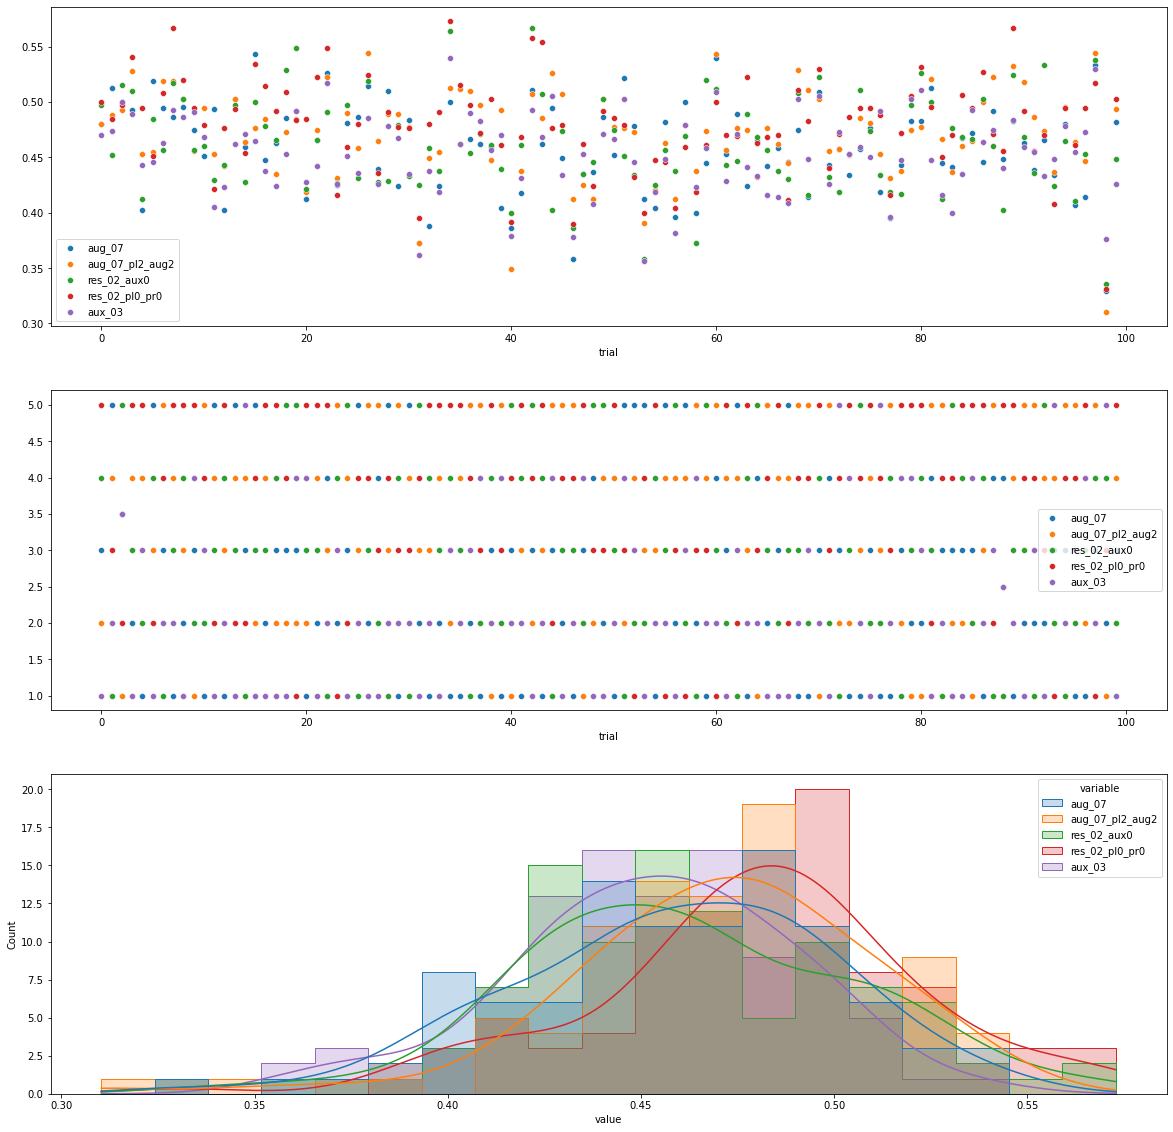

In [16]:
plt.figure(figsize=(20, 20))
plt.subplot(3, 1, 1)
for col in sens_res.columns:
    if col == 'trial':
        continue
    sns.scatterplot(x=sens_res['trial'], y=sens_res[col].values, label=col, markers='X')
plt.legend()
plt.subplot(3, 1, 2)
for col in sens_res.columns:
    if col == 'trial':
        continue
    sns.scatterplot(x=sens_res['trial'], y=sens_res.drop('trial', axis=1).rank(1)[col].values, label=col, markers='X')
plt.legend()
plt.subplot(3, 1, 3)
sns.histplot(data=sens_res.drop('trial', axis=1).melt(), x='value', hue='variable', kde=True, element="step", legend=True)
# plt.legend()
plt.savefig('sens_res.png', facecolor='white')
# plt.show()

In [15]:
agg_df = aggregate_results(Res02Aux0)
metric.optimal_f1(agg_df['label'].values, (agg_df['pred']))

(0.470723306544202, 0.26)

# Threshold analysis

In [19]:
agg_df = aggregate_results(Aug07pl2aug2())
display(subgroup_analysis(agg_df, 'site'))
display(subgroup_analysis(agg_df, 'machine_id'))


,value,PF1,AUC
0,site_overall,"(0.47374062165058944, 0.19)",0.904948
1,site_1,"(0.3807339449541284, 0.24)",0.877522
2,site_2,"(0.5804988662131518, 0.21)",0.927149


,value,PF1,AUC
0,machine_id_overall,"(0.47374062165058944, 0.19)",0.904948
1,machine_id_21,"(0.5954198473282443, 0.21)",0.923716
2,machine_id_29,"(0.5599999999999999, 0.16)",0.927818
3,machine_id_48,"(0.6174496644295302, 0.31)",0.938773
4,machine_id_49,"(0.39493670886075943, 0.26)",0.86656
5,machine_id_93,"(0.33333333333333337, 0.52)",0.779507
6,machine_id_170,"(0.5555555555555556, 0.19)",0.95914
7,machine_id_190,"(0.5, 0.03)",0.960784
8,machine_id_197,NaN,NaN
9,machine_id_210,NaN,NaN


In [35]:
agg_df = aggregate_results(Aug07)
display(subgroup_analysis(agg_df, 'site'))
display(subgroup_analysis(agg_df, 'machine_id'))


,value,PF1,AUC
0,site_overall,"(0.4669703872437358, 0.25)",0.879401
1,site_1,"(0.3711790393013101, 0.25)",0.849230
2,site_2,"(0.5714285714285715, 0.25)",0.904431


,value,PF1,AUC
0,machine_id_overall,"(0.4669703872437358, 0.25)",0.879401
1,machine_id_21,"(0.5217391304347826, 0.18)",0.906191
2,machine_id_29,"(0.5555555555555556, 0.16)",0.907058
3,machine_id_48,"(0.641025641025641, 0.25)",0.905984
4,machine_id_49,"(0.38004750593824227, 0.25)",0.8444
5,machine_id_93,"(0.33333333333333337, 0.84)",0.749676
6,machine_id_170,"(0.5217391304347826, 0.12)",0.934946
7,machine_id_190,"(0.03773584905660378, 0.0)",0.745098
8,machine_id_197,NaN,NaN
9,machine_id_210,NaN,NaN


In [28]:
agg_df = aggregate_results(AuxLoss00)
display(subgroup_analysis(agg_df, 'site'))
display(subgroup_analysis(agg_df, 'machine_id'))


,value,PF1,AUC
0,site_overall,"(0.43645083932853723, 0.3)",0.881930
1,site_1,"(0.36448598130841126, 0.3)",0.844627
2,site_2,"(0.5225653206650832, 0.25)",0.916229


,value,PF1,AUC
0,machine_id_overall,"(0.43645083932853723, 0.3)",0.88193
1,machine_id_21,"(0.5027932960893856, 0.06)",0.923085
2,machine_id_29,"(0.5323741007194244, 0.25)",0.910674
3,machine_id_48,"(0.5655172413793104, 0.35000000000000003)",0.916046
4,machine_id_49,"(0.3869346733668341, 0.3)",0.837247
5,machine_id_93,"(0.33333333333333337, 0.65)",0.833982
6,machine_id_170,"(0.3636363636363636, 0.08)",0.853763
7,machine_id_190,"(0.03773584905660378, 0.0)",0.941176
8,machine_id_197,NaN,NaN
9,machine_id_210,NaN,NaN


In [29]:
agg_df = aggregate_results(Res00aug0)
display(subgroup_analysis(agg_df, 'site'))
display(subgroup_analysis(agg_df, 'machine_id'))


,value,PF1,AUC
0,site_overall,"(0.4675324675324676, 0.42)",0.903614
1,site_1,"(0.375, 0.39)",0.870219
2,site_2,"(0.57002457002457, 0.29)",0.930831


,value,PF1,AUC
0,machine_id_overall,"(0.4675324675324676, 0.42)",0.903614
1,machine_id_21,"(0.6016260162601627, 0.4)",0.936075
2,machine_id_29,"(0.523489932885906, 0.18)",0.905955
3,machine_id_48,"(0.611764705882353, 0.16)",0.950141
4,machine_id_49,"(0.38482384823848237, 0.37)",0.85749
5,machine_id_93,"(0.28571428571428575, 0.77)",0.894942
6,machine_id_170,"(0.5333333333333333, 0.42)",0.945968
7,machine_id_190,"(0.6666666666666666, 0.03)",0.980392
8,machine_id_197,NaN,NaN
9,machine_id_210,NaN,NaN


# Threshold analysis

In [33]:
res = aggregate_results(Aug07pl3)
res.head()

,fold,pred,label,site,machine_id
0,0,0.001930,0,1,49
1,0,0.002849,0,1,49
2,0,0.001238,0,1,49
3,0,0.005902,0,1,49
4,0,0.001191,0,2,29


In [41]:
metric = PercentilePfbeta(percentile_range=[97.5, 99], n_trials=30)
metric(res['pred'].values, res['label'].values)

(0.48775055679287305, 98.3, 0.4603099802070259)

In [39]:
metric = PercentilePfbeta(percentile_range=[97.5, 99], n_trials=30)
metric(res.query('site == 1')['pred'].values, res.query('site == 1')['label'].values), \
    metric(res.query('site == 2')['pred'].values, res.query('site == 2')['label'].values)


((0.39147286821705424, 97.75, 0.3532265750799368),
 (0.5944700460829493, 98.4, 0.4877494222743808))

In [35]:
for fold in range(4):
    print(f'[FOLD {fold} OVERALL]')
    metric = PercentilePfbeta(percentile_range=[97.5, 99], n_trials=30)
    res_fold = res.query('fold == @fold')
    print(metric(res_fold['pred'].values, res_fold['label'].values))
    for site in [1, 2]:
        print(f'\t[FOLD {fold} SITE {site}]')
        metric = PercentilePfbeta(percentile_range=[97, 99.5], n_trials=25)
        res_fold = res.query('fold == @fold and site == @site')
        print('\t', metric(res_fold['pred'].values, res_fold['label'].values))
    print(' ')


    

[FOLD 0 OVERALL]
(0.5267175572519084, 97.85, 0.3826757440270716)
	[FOLD 0 SITE 1]
	 (0.40601503759398494, 97.8, 0.37942486238402595)
	[FOLD 0 SITE 2]
	 (0.6842105263157895, 98.4, 0.5903815845109697)
 
[FOLD 1 OVERALL]
(0.49773755656108604, 98.35, 0.4688744413170951)
	[FOLD 1 SITE 1]
	 (0.4195804195804196, 97.5, 0.353006463943709)
	[FOLD 1 SITE 2]
	 (0.6262626262626263, 98.5, 0.4937117105690159)
 
[FOLD 2 OVERALL]
(0.4770642201834862, 98.2, 0.4380676694983218)
	[FOLD 2 SITE 1]
	 (0.45, 98.0, 0.43591072970535794)
	[FOLD 2 SITE 2]
	 (0.5148514851485149, 98.3, 0.4204965141803817)
 
[FOLD 3 OVERALL]
(0.4716157205240175, 98.3, 0.3490410956234289)
	[FOLD 3 SITE 1]
	 (0.33333333333333337, 98.4, 0.3245849089742594)
	[FOLD 3 SITE 2]
	 (0.5826771653543307, 98.2, 0.37661007361695487)
 


# Use metadata ? 

In [17]:
from sklearn.linear_model import LogisticRegression

In [30]:
for fold_i, (folds, pred_fold) in enumerate(zip(predictions['folds'], predictions['outoffolds'])):
    ds = cfg.dataset(df=train.iloc[folds[1]], image_dir=None)
    labels = ds.get_labels()
    pred = sigmoid(pred_fold).reshape(-1)
    print(metric.optimal_f1(labels, pred))
    stack_x = pd.DataFrame({
        'pred': pred,
        'age': [ds.df_dict[ds.pids[i]]['age'].values[0] / 100 for i in range(len(ds))]
    })
    stack_x['age'] = stack_x['age'].fillna(stack_x['age'].mean())
    model = LogisticRegression()
    model.fit(stack_x, labels.reshape(-1))
    pred2 = model.predict_proba(stack_x)[:, 1]
    print(metric.optimal_f1(labels, pred2))
    

(0.425, 0.64)
(0.42236024844720493, 0.22)
(0.4174757281553398, 0.13)
(0.4161849710982659, 0.05)
(0.5681818181818182, 0.31)
(0.5654450261780104, 0.05)
(0.5, 0.28)
(0.48837209302325585, 0.09)
(0.42276422764227634, 0.65)
(0.42975206611570244, 0.39)


# Segmentation

In [6]:
from configs_seg import *
from configs import *

def extract_encoder(origin_config, target_config, checkpoint_path, export_path, target='.global_encoder'):
    checkpoint = torch.load(checkpoint_path, 'cpu')
    unet_model = origin_config.model(**origin_config.model_params)
    target_model = target_config.model(**target_config.model_params)
    unet_model.load_state_dict(checkpoint['model'])
    eval(f'target_model{target}').load_state_dict(unet_model.encoder._m.state_dict(), strict=False)
    checkpoint['model'] = target_model.state_dict()
    torch.save(checkpoint, export_path)

In [7]:
# extract_encoder(SegBaseline(), Model12(), 'results/seg_baseline/nocv.pt', 'results/seg_baseline/multi_instance.pt', target='.global_encoder')
# extract_encoder(SegBaseline(), Aug07lr0(), 'results/seg_baseline/nocv.pt', 'results/seg_baseline/multi_view.pt', target='.encoder')

In [8]:
cfg = Res02mod2()
# cfg = SegBaseline()
train = pd.read_csv(cfg.train_path).query('cancer == 1')
# train = pd.read_csv(cfg.train_path).query('~finding_birads.isnull()')
dataset = cfg.dataset(
    df=train, 
    image_dir=cfg.image_dir,
    preprocess=cfg.preprocess['test'],
    transforms=cfg.transforms['test'],
    is_test=True,
    **cfg.dataset_params
)

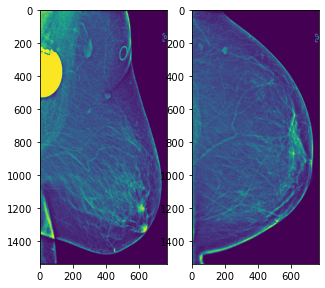

In [13]:
img, label = dataset[15]
_img = (img - img.min()) / (img.max() - img.min())
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(_img[0, 0])
plt.subplot(1, 2, 2)
plt.imshow(_img[1, 0])
plt.show()
plt.close()

In [10]:
model = cfg.model(**cfg.model_params)
checkpoint = torch.load(f'results/{cfg.name}/fold0.pt', 'cpu')['model']
# checkpoint = torch.load(f'results/{cfg.name}/nocv.pt', 'cpu')['model']
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [14]:
model.eval()
with torch.no_grad():
    cam, roi = model.get_global_cam(img[None, :, :, :], return_roi=True)
    # pred = model(img[None, :, :, :])[0]


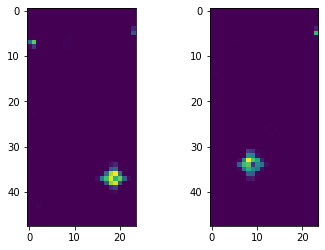

In [15]:
plt.subplot(1, 2, 1)
plt.imshow(cam[0, 0])
plt.subplot(1, 2, 2)
plt.imshow(cam[1, 0])
plt.show()

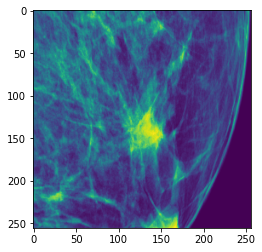

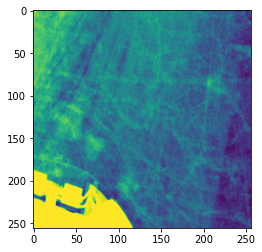

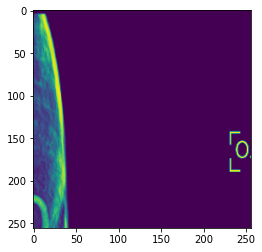

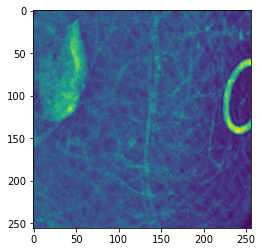

In [16]:
for patch in roi[0]:
    _img = patch[0]
    _img = (_img - _img.amin()) / (_img.amax() - _img.amin() + 1e-4)
    plt.imshow(_img)
    plt.show()